# Data Processing

In [1]:
import numpy as np
import csv
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

from config import *

# Activate below when using Local Workspace
PATH_LOCAL            = './data/IMG/'
PATH_CSV_LOCAL        = "./data/driving_log.csv"

# Activate below when using Udacity Workspace
PATH_UDC            = '/opt/carnd_p3/data/IMG/'
PATH_CSV_UDC        = "/opt/carnd_p3/data/driving_log.csv"

def split_train_valid(env, valid_ratio=0.2):
    """
    Splits the csv containing driving data into training and validation
    :param csv_driving_data: file path of Udacity csv driving data
    :return: train_split, validation_splitz
    """
    # PATH for local and UDC workspace
    if env == 'LOCAL':
        PATH        = PATH_LOCAL
        path_csv    = PATH_CSV_LOCAL
        
    elif env == 'UDC':
        PATH        = PATH_UDC
        path_csv    = PATH_CSV_UDC
        
    else:
        raise('Invalid Argument')

    
    # Reading Data
    with open(path_csv, 'r') as f:
        reader  = csv.reader(f)
        data    = [row for row in reader][1:]
    print("Reading CSV file completed")

    # Split the data
    train_data, valid_data = train_test_split(data, test_size=valid_ratio, random_state=42)

    return train_data, valid_data


def load_data_batch(env, data, augment_data):    
    # PATH
    if env == 'LOCAL':
        PATH        = PATH_LOCAL
        path_csv    = PATH_CSV_LOCAL
        
    elif env == 'UDC':
        PATH        = PATH_UDC
        path_csv    = PATH_CSV_UDC
        
    else:
        raise('Invalid Argument')
        
    # Set training images and batch size
    h, w, c     = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']
    batch_size  = CONFIG['batch_size']

    # Prepare output structures
    X           = np.zeros(shape=(batch_size, h, w, c), dtype=np.float32)
    y_steer     = np.zeros(shape=(batch_size,), dtype=np.float32)

    
    # Shuffle data
    shuffled_data = shuffle(data)

    loaded_elements = 0
    while loaded_elements < batch_size:
        
        # Take one of shuffled data
        ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

        # Cast strings to float32
        steer       = np.float32(steer)

        # Preprocess data when making tranning set
        # when augmnet_data == False, it only uses original, center images
        if augment_data:
            # Exclude 90% of steer == 0 data
            if steer == 0:
                if np.random.rand() > 0.1:
                    continue
                else:
                    delta_correction    = CONFIG['delta_correction']
                    # Randomly choose which camera to use among (central, left, right)
                    # when chosen camera is not the front one, correct steer
                    camera              = random.choice(['front', 'left', 'right'])
                    if camera == 'front':
                        f       = ct_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer
                    elif camera == 'left':
                        f       = lt_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer + delta_correction
                    elif camera == 'right':
                        f       = rt_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer - delta_correction
            else:
                delta_correction    = CONFIG['delta_correction']
                camera              = random.choice(['front', 'left', 'right'])
                if camera == 'front':
                    f       = ct_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer
                elif camera == 'left':
                    f       = lt_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer + delta_correction
                elif camera == 'right':
                    f       = rt_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer - delta_correction

                
             # Mirror images with chance=0.5
            if random.choice([True, False]):
                image   = image[:, ::-1, :]
                steer   *= -1.
                
             # Randomly change brightness
            if CONFIG['input_channels'] == 3:
                image          = cv2.cvtColor(image, code=cv2.COLOR_BGR2HSV)
                image[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                image[:, :, 2] = np.clip(image[:, :, 2], a_min=0, a_max=255)
                image = cv2.cvtColor(image, code=cv2.COLOR_HSV2BGR)
        else:
            f       = ct_path.split('/')[-1]
            image   = np.float32(cv2.imread(PATH + f))
            steer   = steer

        X[loaded_elements]          = image
        y_steer[loaded_elements]    = steer
        loaded_elements             += 1   
    return X, y_steer


def generate_data_batch(env, data, augment_data):
    """
    Generator that indefinitely yield batches of training data
    :param data: list of training data in the format provided by Udacity
    :param batchsize: number of elements in the batch
    :param data_dir: directory in which frames are stored
    :param augment_data: if True, perform data augmentation on training data
    :param bias: parameter for balancing ground truth distribution (which is biased towards steering=0)
    :return: X, Y which are the batch of input frames and steering angles respectively
    """
    while True:

        X, y_steer = load_data_batch(env, data, augment_data)

        yield X, y_steer

if __name__ == '__main__':
    train_data, valid_data = split_train_valid('LOCAL')
    print("Train data shape: {}".format(np.array(train_data).shape))
    print("Valid data shape: {}".format(np.array(valid_data).shape))    
    X_train, y_train = load_data_batch('LOCAL', train_data, augment_data = True)
    print("Image shape: {}".format(X_train.shape))
    print("Steer shape: {}".format(y_train.shape))

Reading CSV file completed
Train data shape: (6428, 7)
Valid data shape: (1608, 7)
Image shape: (1285, 160, 320, 3)
Steer shape: (1285,)


In [2]:
np.mean((abs(y_train)< 0.01))

0.08249027237354085

(array([  1.,   0.,   1.,   2.,   0.,   0.,   2.,   3.,   0.,   7.,   5.,
          4.,   4.,   9.,   5.,   7.,   7.,  10.,   9.,  13.,  19.,  18.,
         30.,  18.,  13.,  31.,  30.,  43.,  27.,  18.,  88.,  43.,  30.,
         31.,  30., 101.,  53.,  31.,  29.,  46.,  78.,  25.,  24.,  36.,
         40.,  46.,  30.,  15.,  24.,  24.,  11.,  25.,   9.,  16.,   9.,
          2.,  10.,   5.,   4.,   3.,   3.,   7.,   2.,   4.,   1.,   3.,
          1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.6009356 , -0.58412623, -0.5673169 , -0.5505075 , -0.53369814,
        -0.5168888 , -0.50007945, -0.48327008, -0.46646073, -0.44965136,
        -0.43284202, -0.41603267, -0.3992233 , -0.38241395, -0.36560458,
        -0.34879524, -0.3319859 , -0.31517652, -0.29836717, -0.2815578 ,
        -0.26474845, -0.24

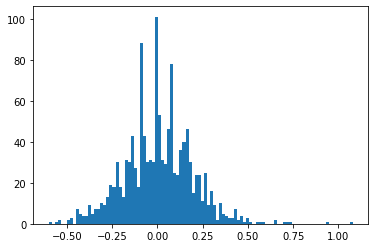

In [3]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins = 100)

(-0.5, 319.5, 159.5, -0.5)

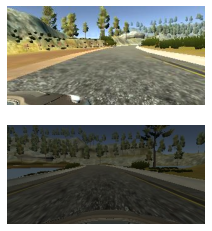

In [4]:
import matplotlib.pyplot as plt
idx = np.int(CONFIG['batch_size'] * np.random.rand())

plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(np.uint8(X_train[idx]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(np.uint8(X_train[idx+1]), cv2.COLOR_BGR2RGB))
plt.axis('off')

# Model

In [6]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout
from dataPreprocess import split_train_valid, generate_data_batch
from config import *

ENV = 'LOCAL'

h, w, c     = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']

## Load Dataset
train_data, valid_data = split_train_valid(ENV)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(h, w, c)))
model.add(Cropping2D(cropping=((20,20), (0,0)) ) )
model.add(Conv2D(24, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(36, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(48, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

print(model.summary())

# model.compile(loss = 'mse', optimizer = 'adam')
# model.fit_generator(generator = generate_data_batch(ENV, train_data, augment_data= True),
#                     steps_per_epoch= 5, epochs=15,
#                     validation_data= generate_data_batch(ENV, valid_data, augment_data= False),
#                     validation_steps=2)

# model.save('model.h5')

Reading CSV file completed
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 120, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 35, 64)         27712     
____________